# RL- DQN Agent CartPole
- 강화학습 분야의 유명한 'Cartpole' 예제
-DQN 타입의 에이전트로 완성하는 노트북 프로젝트
-강화학습 기반의 에이전트 훈련, 검증, 데이터 수집 방법 이해 가능
-https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf
-https://raw.githubusercontent.com/tensorflow/agents/master/docs/tutorials/images/cartpole.png

## 1) Environment Set Up

In [1]:
! sudo apt-get update
! sudo apt-get install -y xvfb ffmpeg freeglut3-dev
! pip install 'imageio==2.4.0'
! pip install pyvirtualdisplay
! pip install tf-agents[reverb]
! pip install pyglet

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-6).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already th

In [2]:
from __future__ import absolute_import, division, print_function
# 기본 라이브러리
import base64
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import imageio
import PIL.Image
import pyvirtualdisplay
import reverb
# 구글 머신러닝 플랫폼 TF
import tensorflow as tf
# TF의 강화학습 요소: TF Agent
# 환경, 에이전트, 성능평가 요소 임포트
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
# 학습 과정 시각화 요소 임포트
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

RuntimeError: ignored

In [3]:
# Set up a virtual display
# for rendering OpenAI gym environment
display = pyvirtualdisplay.Display(visible=0,size=(1600,800)).start()

In [4]:
tf.version.VERSION

'2.13.0'

In [5]:
# 반복 회수
num_iterations = 5000
# 100회 마다 학습성과 수집 (for the replay_buffer)
initial_collect_steps = 100
collect_steps_per_iteration = 1
replay_buffer_max_length = 10000
# 일괄 실행 초기화
batch_size = 64
learning_rate = 1e-3
# 로그 출력 간격
log_interval = 200
# 학습 성능 검증
num_eval_episodes = 10
eval_interval = 1000

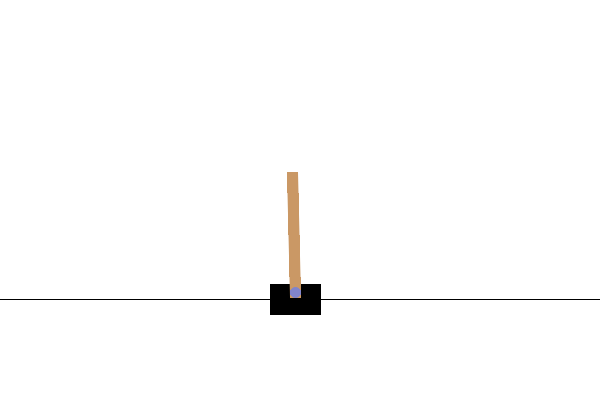

In [6]:
# 환경 불러오기
env = suite_gym.load('CartPole-v0')
env.reset()
PIL.Image.fromarray(env.render())

In [7]:
# RL observation, reward, action 정보
print("\n observation \n",env.time_step_spec().observation) # [카트의 위치, 속도, 막대의 각위치, 속도]
print("\n reward \n",env.time_step_spec().reward)
print("\n action \n",env.action_spec()) # 0 - 왼쪽, 1 - 오른쪽


 observation 
 BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])

 reward 
 ArraySpec(shape=(), dtype=dtype('float32'), name='reward')

 action 
 BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.04072805,  0.00659013, -0.02964219,  0.03313814], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})


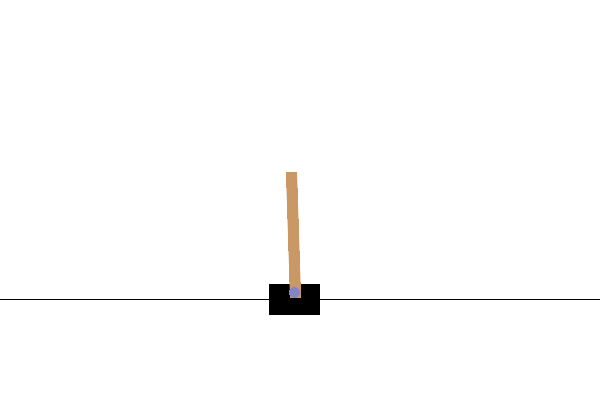

In [8]:
# 초기 동작 확인
time_step = env.reset()
print(time_step)
PIL.Image.fromarray(env.render())

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.04059625,  0.20212434, -0.02897943, -0.26874787], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


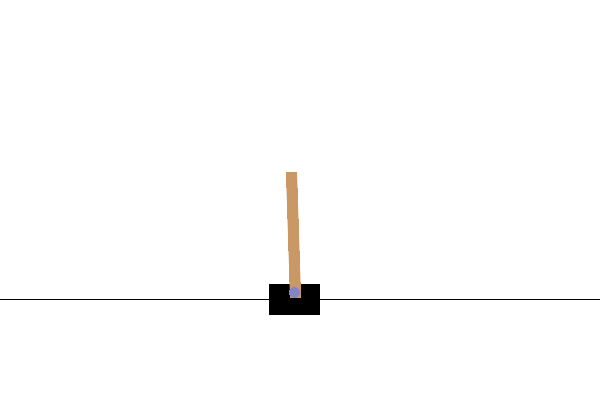

In [9]:
# 다음 동작 확인
action = np.array(1,dtype = np.int32)
next_time_step = env.step(action)
print(next_time_step)
PIL.Image.fromarray(env.render())

In [10]:
# 훈련 및 검증 환경 로딩
train_py_env = suite_gym.load('CartPole-v0')
eval_py_env = suite_gym.load('CartPole-v0')
# Py -> Tf CartPole 환경으로 변환
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## 2) Agent Set Up

In [11]:
fc_layers_params = (100,50)
# action_spec을 tf로 변환. tf 연산을 위해!
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1
print(action_tensor_spec) # 출력결과는 기존의 env.action_spec과 별 다를게 없음

BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1))


In [12]:
# dense 함수 구축
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation = tf.keras.activations.relu,
      kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2.0, mode= 'fan_in', distribution='truncated_normal')
  )

In [13]:
# Q-network: 개별 액션에 대응하여 Q값을 생성하는 Dense layer 결합
dense_layers = [dense_layer(num_units) for num_units in fc_layers_params]

# 각 액션에 대한 Q-value를 추정, 마지막 layer
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation = None,
    kernel_initializer = tf.keras.initializers.RandomUniform(minval=-0.03, maxval = 0.03),
    bias_initializer = tf.keras.initializers.Constant(-0.2))

q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [14]:
# DQN_Agent 초기화
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate) # optimizer 정의
train_step_counter = tf.Variable(0) #학습 횟수 기록 변수 초기화 0

agent = dqn_agent.DqnAgent( # Tensorflow Agents lib 활용
    train_env.time_step_spec(), # 환경에 대한 상태 tensor 정보
    train_env.action_spec(), # 취할 수 있는 액션에 대한 tensor 정보
    q_network = q_net, # 해당 액션에 대한 q-value를 추출하기 위한 q-network
    optimizer = optimizer, # opitmizer Adam 사용
    td_errors_loss_fn = common.element_wise_squared_loss, # 손실함수 MSE
    train_step_counter = train_step_counter) # 학습 횟수 기록 변수

# Agent 초기화
agent.initialize()

## 3) Policy Set Up
- 환경에서 Agent 행동 방식 정의, 원하는 결과를 얻을 때까지 훈련 지속
- 이번 환경에서 원하는 결과: 움직이는 카트 위에 막대 세워두기
- 이번 정책은 time-step 마다 대응하는 0 좌측 or 1 우측 이동 동작 반환

In [15]:
# 기본 정책: Agent의 성능 검증 및 배포
agent_policy = agent.policy
# 보조 정책: Agent의 데이터 수집(동작 및 결과 데이터)
collect_policy = agent.collect_policy

# 정책과 Agent는 서로 독립적인 관계
# 무작위 동작 수행 정책
random_policy = random_tf_policy.RandomTFPolicy(
    train_env.time_step_spec(),
    train_env.action_spec()
)

In [16]:
# 예제 환경인 CartPole-v0 로딩
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0')
)
# 초기화
time_step = example_environment.reset()

# random_policy 기반 method 실행. method 반환 값, PolicyStep 확인
random_policy.action(time_step) # policy.action(time_step) 정책 기반 동작 함수

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, state=(), info=())

## 4) Metrics and Evaluation
- 정책 평가 지표: average return (평균 보상)
- 다수의 에피소드 실행 결과, 평균 보상 생성
- 정책, 환경, 에피소드 수 입력 => 정책의 평균 보상 출력
- 이외의 다양한 성능 지표 하단의 링크 참조
- https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [17]:
# 정책의 average return 계산
def compute_avg_return(environment,policy,num_episodes=10):
  total_return = 0.0 # 누적 episode의 return 값 저장하는 변수

  for _ in range(num_episodes): # num_episodes 만큼 실행
    time_step = environment.reset() # 환경 초기화
    episode_return = 0.0 # 에피소드 별 return 저장할 변수
    while not time_step.is_last(): # episode가 끝날 때 까지 반복
      action_step = policy.action(time_step)  #policy 기반 time_step 환경에서의 액션 실행
      time_step = environment.step(action_step.action) # 액션 적용한 그 다음 환경 업데이트
      episode_return += time_step.reward #에피소드 reward 저장

    total_return += episode_return #모든 에피소드의 누적 reward 저장

  avg_return = total_return / num_episodes # 평균 return 계산
  return avg_return.numpy()[0] #Tensor 값을 numpy 배열로 변환후 스칼라 값으로 반환

In [18]:
compute_avg_return(eval_env,random_policy,num_eval_episodes) # 랜덤 기반 정책 성능 출력(대략적인 기본 성능 파악을 위함)

26.0

## 5) Replay Buffer 경험치 저장
- "reverb" 리플레이 시스템, 환경 변화를 반영한 에이전트 동작 재현
- https://deepmind.com/research/open-source/Reverb
- Agent가 실행하는 행동 데이터를 경험치로 수집하고 훈련에 활용
- replay buffer: specs data로 구성
- specs: agent.collect_data_spec으로 수집한 tensor type의 데이터

In [19]:
# Agent 경험치 관리를 위한 Table 유형 선언
table_name = 'uniform_table' # table 이름
replay_buffer_signature = tensor_spec.from_spec(agent.collect_data_spec) # agent.collect_data_spec으로부터 replay buffer 정의
#print('\nBefore add_outer_dim\n',replay_buffer_signature)
replay_buffer_signature = tensor_spec.add_outer_dim(replay_buffer_signature) # 추가적인 데이터를 차원을 추가하여 정의
#print('\nAfter add_outer_dim\n',replay_buffer_signature)

# reverb 테이블
table = reverb.Table( # reverb.Table lib 활용
    table_name, # table 이름
    max_size = replay_buffer_max_length, #replay_buffer 최대 용량 지정
    sampler = reverb.selectors.Uniform(), # reverb.selectors를 균등하게 뽑아 sampler 지정
    remover = reverb.selectors.Fifo(), # first-in-first-out으로 가장 오래된 데이터를 먼저 제거하도록 지정
    rate_limiter = reverb.rate_limiters.MinSize(1), # replay buffer update 속도 지정, 최소 한 개의 값을 추가할 수 있을 때, 추가 허용
    signature = replay_buffer_signature) # 위에서 지정한 replay_buffer_signature를 signature로 지정
#print('\ntable\n',table)

In [20]:
# reverb 연산용 서버 구축
reverb_server = reverb.Server([table])

In [21]:
# replay buffer로 경험치 갱신
replay_buffer = reverb_replay_buffer.ReverbReplayBuffer( # ReplayBuffer 생성
    agent.collect_data_spec, # agent.collect_data_spec 값을
    table_name = table_name, #table_name으로
    sequence_length=2, #sequence를 두 개씩 묶어
    local_server = reverb_server # reverb_server에 업데이트
)

In [22]:
# 변화하는 관측치 누적
rb_observer = reverb_utils.ReverbAddTrajectoryObserver( # 관측치 데이터 수집
    replay_buffer.py_client, # python client 객체를 통해 관측치 데이터 replay buffer에 추가
    table_name,
    sequence_length = 2
)

In [23]:
# agent 경험치 출력
print('\n경험치 저장 정보\n',agent.collect_data_spec)
print('\n경험치 저장 목록\n',agent.collect_data_spec._fields)


경험치 저장 정보
 Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

경험치 저장 목록
 ('step_type', 'observation', 'action', 'policy_info', 'next_step_type', 'reward', 'discount')


## 4) Data Collection

In [24]:
# PyDriver로 환경에서 에이전트의 경험치 수집
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
        random_policy, use_tf_function=True),
    [rb_observer],
    max_steps = initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([ 0.07015748,  0.78195965, -0.01711806, -1.0521322 ], dtype=float32),
  'reward': array(1., dtype=float32),
  'step_type': array(1, dtype=int32)}),
 ())

In [25]:
# Dataset Pipeline 구현
dataset = replay_buffer.as_dataset( # replay_buffer dataset 생성하기
    num_parallel_calls= 3, # 병렬 처리 가능한 셀 개수
    sample_batch_size = batch_size, #batch_size 지정
    num_steps=2).prefetch(3) # sequence_length와 num_steps 개수 같아야 함, 미리 batch 3개 대기

dataset # dataset 출력

<_PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 4), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [26]:
iterator = iter(dataset) # iter로 변환, tensorflow 활용 위해
print(iterator)

## 5) Training the Agent

In [27]:
# 셀 실행 시간 출력
try:
  %%time
except:
  pass

# agent.train 함수 생성
agent.train = common.function(agent.train)
agent.train_step_counter.assign(0) # step_counter 횟수 0으로 초기화

avg_return = compute_avg_return(eval_env,agent.policy,num_eval_episodes) #compute_avg_return 함수 통해 avg_return 계산
returns = [avg_return] #avg_return return 리스트에 저장

time_step = train_py_env.reset() # 환경 초기화

collect_driver = py_driver.PyDriver( # 경험치 저장
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
        agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps = collect_steps_per_iteration)

In [28]:
for _ in range(num_iterations): # num_iteration만큼 학습 진행
  time_step,_ = collect_driver.run(time_step) # collect_driver로 time_step 데이터 저장
  experience, unused_info = next(iterator) # experience 저장
  train_loss = agent.train(experience).loss # loss 계산
  step = agent.train_step_counter.numpy() #step_횟수 추출

  if step%log_interval == 0: #log 출력
    print('step={0}:loss={1}'.format(step,train_loss))

  if step%eval_interval == 0:#Average Return 중간 값 출력
    avg_return = compute_avg_return(eval_env,agent.policy,num_eval_episodes)
    print('step={0}: Average Return = {1}'.format(step,avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step=200:loss=31.80306053161621
step=400:loss=6.184028148651123
step=600:loss=6.697829246520996
step=800:loss=476.2547912597656
step=1000:loss=299.0123596191406
step=1000: Average Return = 80.9000015258789
step=1200:loss=123.94188690185547
step=1400:loss=128.4800567626953
step=1600:loss=22.746545791625977
step=1800:loss=34.31918716430664
step=2000:loss=24.787948608398438
step=2000: Average Return = 200.0
step=2200:loss=29.481889724731445
step=2400:loss=504.35467529296875
step=2600:loss=28.287540435791016
step=2800:loss=15.00159740447998
step=3000:loss=24.677906036376953
step=3000: Average Return = 200.0
step=3200:loss=19.598806381225586
step=3400:loss=54.7230339050293
step=3600:loss=102.916015625
step=3800:loss=386.015625
step=4000:loss=87.99348449707031
step=4000: Average Return = 200.0
step=4200:loss=1288.1181640625
step=4400:loss=281.3272705078125
step=4600:loss=164.076416015625
step=4800:loss=320.8453369140625
step=5000:loss=10123.8564453125
step=5000: Average Return = 200.0


## 6) visualization

(33.575, 250.0)

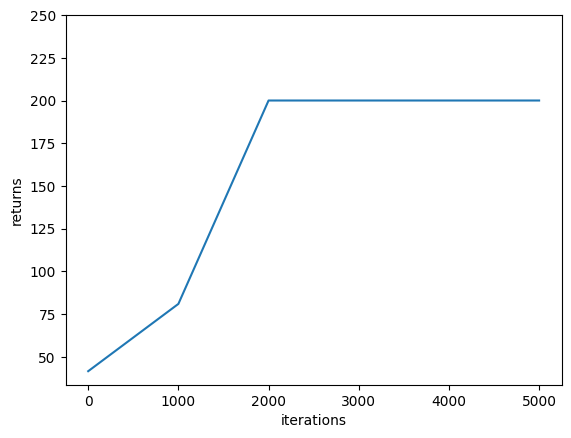

In [39]:
iterations = range(0,num_iterations+1,eval_interval)
plt.plot(iterations,returns)
plt.xlabel('iterations')
plt.ylabel('returns')
plt.ylim(top=250)
# 대략 return이 33에서 200 정도 까지 상승함

In [29]:
# Video enbed_mp4
def embed_mp4(filename):
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width ="640" height = "480" controls>
      <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())


  return IPython.display.HTML(tag)

In [35]:
# Agent CartPole Video Encoding
def create_policy_eval_video(policy,filename,num_episodes=5,fps=30):
  filename = filename+".mp4"
  with imageio.get_writer(filename,fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

In [36]:
# 학습한 agent 비디오 임베딩
create_policy_eval_video(agent.policy,"trained-agent")

In [37]:
# Random_policy로 진행한 agent 임베딩 s
create_policy_eval_video(random_policy,"random-agent")